In [10]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 

warnings.filterwarnings('ignore')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
pd.set_option('display.max_row',10000)
pd.set_option('display.max_columns',40)

In [4]:
df = pd.read_csv('Dados/data_tratado.csv',sep=';')
df.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')

In [5]:
def tirando_horas_sem_radiacao(df):
    condicao_irradiacao = (df.HORA<=18) & (df.HORA>=5)
    df = df[condicao_irradiacao]
    return df


ts = tirando_horas_sem_radiacao(df)
ts.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')
ts.loc[:,'MES'] = ts.loc[:,'DT_MEDICAO'].dt.month
#criando a coluna ano
ts.loc[:,'ANO'] = ts.loc[:,'DT_MEDICAO'].dt.year
ts_dia = ts.groupby('DT_MEDICAO').agg({'RAD':'sum','CHUVA':'sum','ANO':'mean','MES':'mean','PRE_INS':'mean','UMD_MIN':'mean','PTO_MIN':'mean','VEN_DIR':'mean','TEM_MAX':'mean'})

ts.set_index('DT_MEDICAO',inplace=True)

In [6]:
# funçãoque cria a janela d previsão com N elementos

def create_lags(df,N):
    for i in range(N):
        df['Lag'+str(i+1)] = df.RAD.shift(i+1)
    return df

In [7]:
ts['day'] = ts.index.day
ts['dayofyear'] = ts.index.dayofyear
ts['weekday'] = ts.index.weekday
ts['weekofyear'] = ts.index.weekofyear

ts['month'] = ts.index.month
ts['is_month_start'] = ts.index.is_month_start
ts['is_month_end'] = ts.index.is_month_end

ts['year'] = ts.index.year
ts['is_year_start'] = ts.index.is_year_start
ts['ano_fim'] = ts.index.is_year_end

ts['quarter'] = ts.index.quarter
ts['quarter_comeco'] = ts.index.is_quarter_start
ts['quarter_fim'] = ts.index.is_quarter_end

ts = ts.dropna()

In [8]:
# No trabalho a captação de dados eram de 10 em 10 minutos então fez um lag de 60 (1hora)
# nossa captação é de hora em hora então faremos lag de 24h
ts = create_lags(ts,14)
ts= ts.dropna()
ts_copy = ts.copy()

In [9]:
ts.head()

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,UMD_MIN,PTO_MAX,VEN_DIR,CHUVA,PRE_MIN,UMD_MAX,VEN_VEL,PTO_MIN,TEM_MAX,VEN_RAJ,...,is_year_start,ano_fim,quarter,quarter_comeco,quarter_fim,ts_lag1,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11,Lag12,Lag13,Lag14
DT_MEDICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,SAO PAULO - MIRANTE,924.4,24.4,-23.496294,924.4,SP,48.201,16.2,24.7,-46.620088,58.0,16.3,340.0,0.0,923.9,59.0,1.8,16.2,25.0,5.3,...,False,False,1,False,False,0.000,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737,732.567,115.361
2015-01-02,SAO PAULO - MIRANTE,925.2,24.7,-23.496294,925.2,SP,285.042,16.6,24.8,-46.620088,58.0,16.7,330.0,0.0,924.4,60.0,1.9,16.2,25.3,5.5,...,False,False,1,False,False,48.201,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737,732.567
2015-01-02,SAO PAULO - MIRANTE,925.7,24.8,-23.496294,925.7,SP,834.522,16.8,25.3,-46.620088,55.0,17.2,318.0,0.0,925.2,59.0,2.8,16.5,26.6,5.1,...,False,False,1,False,False,285.042,285.042,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737
2015-01-02,SAO PAULO - MIRANTE,926.2,27.7,-23.496294,926.2,SP,1136.050,17.6,26.4,-46.620088,52.0,17.6,319.0,0.0,925.7,56.0,1.5,16.7,27.8,5.3,...,False,False,1,False,False,834.522,834.522,285.042,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176
2015-01-02,SAO PAULO - MIRANTE,926.1,28.4,-23.496294,926.2,SP,2073.788,17.5,27.8,-46.620088,47.0,18.0,290.0,0.0,926.0,54.0,2.7,16.6,29.7,7.2,...,False,False,1,False,False,1136.050,1136.050,834.522,285.042,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439


In [11]:
# Define X e saídas Y e divide em 70% para treino e 30% pra teste
cols = ['TEM_INS', 'UMD_INS','VEN_RAJ', 'CHUVA','HORA','day', 'dayofyear', 'weekday', 'weekofyear', 'month',
        'is_month_start', 'is_month_end', 'year', 'is_year_start', 'ano_fim','quarter', 'quarter_comeco', 
        'quarter_fim', 'Lag1', 'Lag2', 'Lag3','Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8', 'Lag9', 'Lag10', 'Lag11',
        'Lag12', 'Lag13', 'Lag14']

X = ts[cols]

y=np.log(ts['RAD']+1)  # log de y +1 pra não dar problema se zero!
X.shape, y.shape

((35784, 32), (35784,))

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [15]:
# Define pipeline
pipe = Pipeline([('minmax', MinMaxScaler()),
                    ('dtr_regr', DecisionTreeRegressor(max_depth=5))])

In [16]:
# Ajusta o modelo nos dados de treino
from sklearn import set_config
set_config(display='diagram')

pipe.fit(X_train, y_train)

Pipeline(steps=[('minmax', MinMaxScaler()),
                ('dtr_regr', DecisionTreeRegressor(max_depth=5))])

In [17]:
#X_test = X_test[['UMD_MIN', 'TEM_MAX']]
y_pred = pipe.predict(X_test)
y_hat= pipe.predict(X_train)

In [18]:
y_pred

array([0.01430903, 8.02265319, 7.74699717, ..., 6.03760521, 3.43224102,
       7.74699717])

In [19]:
y_test.head()

DT_MEDICAO
2018-04-23    0.000000
2016-12-20    8.104944
2017-10-28    7.710475
2021-12-14    7.889000
2021-05-17    8.028933
Name: RAD, dtype: float64

In [20]:
y_test.shape, y_pred.shape

((11809,), (11809,))

In [21]:
pipe.score(X_test, y_test)

0.9516419523946547

In [22]:
pipe.score(X_train, y_train)

0.9505779211419116

In [23]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred,squared=False)

0.5712102863795803

In [24]:
mean_squared_error(y_train, y_hat,squared=False)

0.5730035163718268

In [25]:
# Cálculo do coeficiente de determinação R2
r2_score(y_test,y_pred)

0.9516419523946547

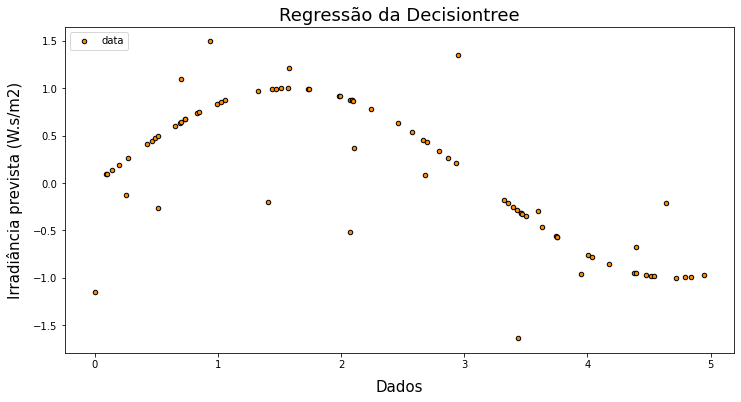

In [59]:
fig = plt.figure(figsize=(12, 6))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
plt.title('Regressão da Decisiontree',fontsize=18)
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
#plt.plot(X_test, y_pred, color="cornflowerblue", label="max_depth=5", linewidth=2)
ax.set_ylabel('Irradiância prevista (W.s/m2)', fontsize=15, fontweight="normal", labelpad=10)
ax.set_xlabel('Dados', fontsize=15, fontweight="normal", labelpad=10)
plt.legend(loc='upper left');

In [40]:
pd.DataFrame(y_test-y_pred).describe().T

,count,mean,std,min,25%,50%,75%,max
RAD,11809.0,-0.001155,0.571233,-6.037605,-0.190561,-0.006844,0.245408,4.098249


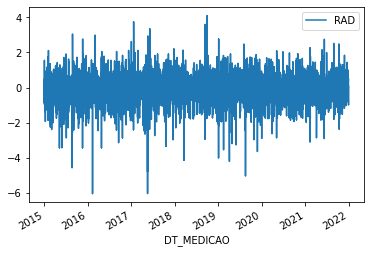

In [41]:
resid = y_test-y_pred
pd.DataFrame(resid).plot();

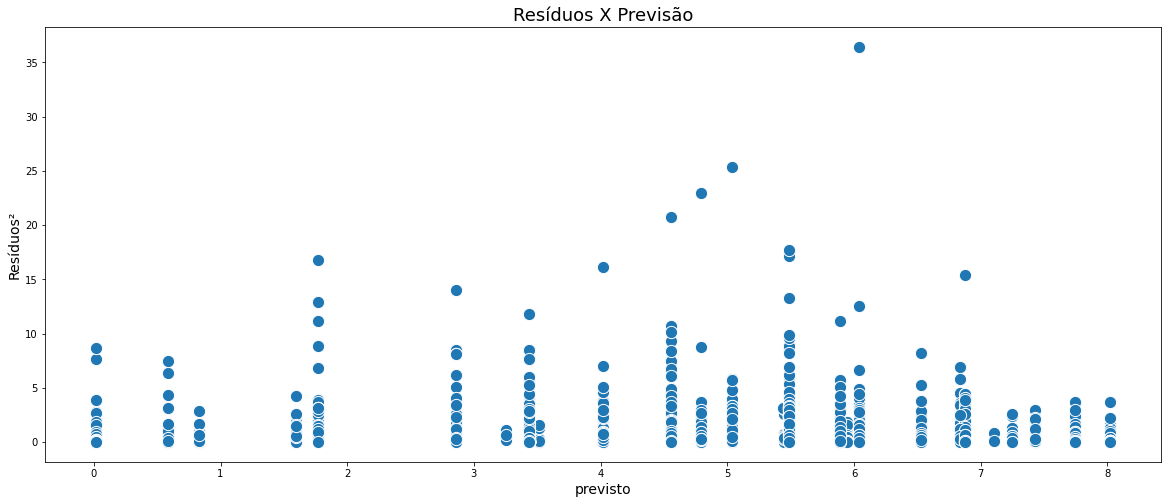

In [60]:
ax = sns.scatterplot(x=y_pred,y=resid**2,s=150) 
ax.figure.set_size_inches(20,8)
ax.set_title('Resíduos X Previsão',fontsize=18)
ax.set_xlabel('previsto',fontsize=14)
ax.set_ylabel('Resíduos²',fontsize=14);

## Com StandardScaler

In [35]:
def pipeline_regression_scaler(scaler= 'M'):
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
    from sklearn.metrics import mean_squared_error
    
    if scaler =='S':
        pipe = Pipeline([('standardscaler',StandardScaler() ),
                        ('model_regression',DecisionTreeRegressor(max_depth=5))])
    elif scaler=='M':
        pipe = Pipeline([('minmax',MinMaxScaler() ),
                        ('model_regression',DecisionTreeRegressor(max_depth=5))])
    elif scaler=='R':
        pipe = Pipeline([('robust',RobustScaler() ),
                        ('model_regression',DecisionTreeRegressor(max_depth=5))])
    else:
        print('Tente M: minmax, S: standard e R: robust')
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_hat= pipe.predict(X_train)
    print(f'O formato do  y_test é {y_test.shape}, e do y_pred é {y_pred.shape}')
    a_test = pipe.score(X_test, y_test)
    a_train = pipe.score(X_train, y_train)
    print(f'O acurácia do  test é {a_test.round(3)}, e do train é {a_train.round(3)}')
    MSE_test = mean_squared_error(y_test, y_pred,squared=False)
    MSE_train = mean_squared_error(y_train, y_hat,squared=False)
    print(f'O MSE do  test é {MSE_test.round(3)}, e do train é {MSE_train.round(3)}')
    
    return y_pred,y_hat

In [36]:
 y_pred,y_hat = pipeline_regression_scaler("M")


O formato do  y_test é (11809,), e do y_pred é (11809,)
O acurácia do  test é 0.952, e do train é 0.951
O MSE do  test é 0.571, e do train é 0.573


In [37]:
pipeline_regression_scaler("S")

O formato do  y_test é (11809,), e do y_pred é (11809,)
O acurácia do  test é 0.952, e do train é 0.951
O MSE do  test é 0.571, e do train é 0.573


(array([0.01430903, 8.02265319, 7.74699717, ..., 6.03760521, 3.43224102,
        7.74699717]),
 array([7.74699717, 3.43224102, 6.03760521, ..., 0.01430903, 7.74699717,
        6.87915146]))

In [38]:
pipeline_regression_scaler("R")

O formato do  y_test é (11809,), e do y_pred é (11809,)
O acurácia do  test é 0.952, e do train é 0.951
O MSE do  test é 0.571, e do train é 0.573


(array([0.01430903, 8.02265319, 7.74699717, ..., 6.03760521, 3.43224102,
        7.74699717]),
 array([7.74699717, 3.43224102, 6.03760521, ..., 0.01430903, 7.74699717,
        6.87915146]))

In [30]:
pipeline_regression_scaler("d")

Tente M: minmax, S: standard e R: robust


UnboundLocalError: local variable 'pipe' referenced before assignment

In [43]:
results = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
results.sort_index(inplace=True)

In [44]:
results=pd.DataFrame({'y_train':y_train,'y_hat':y_hat})
results.sort_index(inplace=True)